torch.Size([7000, 500]) torch.Size([7000, 1]) torch.Size([3000, 500]) torch.Size([3000, 1])
epoch 1,train_loss 0.017197,test_loss 0.016579
epoch 2,train_loss 0.016889,test_loss 0.016249
epoch 3,train_loss 0.016663,test_loss 0.016006
epoch 4,train_loss 0.016495,test_loss 0.015823
epoch 5,train_loss 0.016368,test_loss 0.015684
epoch 6,train_loss 0.016271,test_loss 0.015577
epoch 7,train_loss 0.016194,test_loss 0.015492
epoch 8,train_loss 0.016132,test_loss 0.015424
epoch 9,train_loss 0.016081,test_loss 0.015369
epoch 10,train_loss 0.016037,test_loss 0.015322
epoch 11,train_loss 0.015999,test_loss 0.015282
epoch 12,train_loss 0.015964,test_loss 0.015246
epoch 13,train_loss 0.015933,test_loss 0.015213
epoch 14,train_loss 0.015903,test_loss 0.015184
epoch 15,train_loss 0.015875,test_loss 0.015156
epoch 16,train_loss 0.015847,test_loss 0.015130
epoch 17,train_loss 0.015821,test_loss 0.015105
epoch 18,train_loss 0.015795,test_loss 0.015080
epoch 19,train_loss 0.015769,test_loss 0.015057
epoch

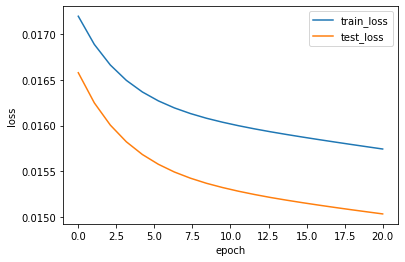

In [2]:
import torch
import numpy as np
import random
from IPython import display
import torch.utils.data as Data

num_inputs = 500
num_examples = 10000
true_w = torch.ones(500,1)*0.0056
true_b = 0.028
#随机生成的数据样本
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)#行*列=10000*500
labels = torch.mm(features,true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) #扰动项
#训练集和测试集上的样本&标签数----真实的特征和样本
trainfeatures = features[:7000]
trainlabels = labels[:7000]
testfeatures = features[7000:]  
testlabels = labels[7000:]
print(trainfeatures.shape,trainlabels.shape,testfeatures.shape,testlabels.shape)

#获得数据迭代器
batch_size = 50 # 设置小批量大小
def load_array(data_arrays, batch_size, is_train=True):  #自定义函数
    #"""构造一个PyTorch数据迭代器。"""
    dataset = Data.TensorDataset(*data_arrays)#features 和 labels作为list传入，得到PyTorch的一个数据集
    return Data.DataLoader(dataset, batch_size, shuffle=is_train,num_workers=0)#返回的是实例化后的DataLoader
train_iter = load_array([trainfeatures,trainlabels],batch_size)
test_iter = load_array([testfeatures,testlabels],batch_size)

#定义超参数
num_inputs=500
num_hiddens = 256
num_outputs = 1
#定义参数
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs,num_hiddens)), dtype=torch.float32)  
b1 = torch.zeros(1, dtype=torch.float32)  
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens,num_outputs)), dtype=torch.float32)  
b2 = torch.zeros(1, dtype=torch.float32)  
params = [W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad = True)#设置为true，追踪并记录所有在计算图上的操作（正向积累）

def relu(x):  
    x = torch.max(input=x,other=torch.tensor(0.0))  
    return x 

#定义模型  
def net(X):  
    X = X.view((-1,num_inputs)) #将数据进行展平，对于空间结构的数据生效
    H = relu(torch.matmul(X,W1)+b1)  
    return torch.matmul(H,W2)+b2  
loss = torch.nn.MSELoss()
def SGD (params,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size
#记录列表（list），存储训练集和测试集上经过每一轮次，loss的变化
def train (net,train_iter,test_iter,loss,num_epochs,batch_size,params = None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):#外循环控制循环轮次
        #step1在训练集上，进行小批量梯度下降更新参数
        for X,y in train_iter:#内循环控制训练批次
            y_hat = net(X)
            l = loss(y_hat,y)#l.size = torch.Size([]),即说明loss为表示*标量*的tensor`
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr,batch_size)
            else:
                optimizer.step()
        #step2 每经过一个轮次的训练， 记录训练集和测试集上的loss
        train_labels = trainlabels.view(-1,1)  
        test_labels = testlabels.view(-1,1) 
        train_loss.append((loss(net(trainfeatures),train_labels)).item())#！注意要取平均值
        test_loss.append((loss(net(testfeatures),test_labels)).item())
        print("epoch %d,train_loss %.6f,test_loss %.6f"%(epoch+1,train_loss[epoch],test_loss[epoch])) 
    return train_loss, test_loss

lr=0.01
num_epochs = 20
#batch_size、params epc已经定义
train_loss, test_loss = train (net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)#每一给optimizer,默认None

import matplotlib.pyplot as plt
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

torch.Size([14000, 200]) torch.Size([14000, 1]) torch.Size([6000, 200]) torch.Size([6000, 1])
epoch 1,train_loss 32.818668,test_loss 33.047234
epoch 2,train_loss 29.763063,test_loss 30.041527
epoch 3,train_loss 26.843542,test_loss 27.103823
epoch 4,train_loss 24.333836,test_loss 24.498997
epoch 5,train_loss 22.103399,test_loss 22.288319
epoch 6,train_loss 20.242859,test_loss 20.459768
epoch 7,train_loss 18.379824,test_loss 18.508512
epoch 8,train_loss 16.787054,test_loss 16.945805
epoch 9,train_loss 15.316413,test_loss 15.494952
epoch 10,train_loss 13.986809,test_loss 14.163454
epoch 11,train_loss 12.796457,test_loss 12.986771
epoch 12,train_loss 11.763365,test_loss 11.954306
epoch 13,train_loss 10.748314,test_loss 10.919194
epoch 14,train_loss 9.865685,test_loss 10.024225
epoch 15,train_loss 9.078724,test_loss 9.221390
epoch 16,train_loss 8.355811,test_loss 8.472768
epoch 17,train_loss 7.732056,test_loss 7.825146
epoch 18,train_loss 7.099344,test_loss 7.169745
epoch 19,train_loss 6.56

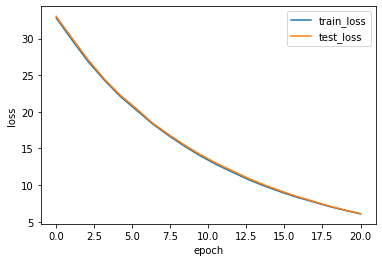

In [3]:
import torch
import numpy as np
import random
from IPython import display
import torch.utils.data as Data

num_inputs = 200
#1类
x1 = torch.normal(2,1,(10000,num_inputs))
y1 = torch.ones(10000,1)#标签1
x1_train = x1[:7000]
x1_test = x1[7000:]
#0类
x2 = torch.normal(-2,1,(10000,num_inputs))
y2 = torch.zeros(10000,1)#标签1
x2_train = x1[:7000]
x2_test = x1[7000:]
#合并数据----按行合并，即dim=0，且分训练集和测试集
    ##合并训练集数据（包括特征和标签）
trainfeatures=torch.cat((x1_train,x2_train),0).type(torch.FloatTensor)
trainlabels = torch.cat((y1[:7000],y2[:7000]),0).type(torch.FloatTensor)
    ##合并测试集数据
testfeatures=torch.cat((x1_test,x2_test),0).type(torch.FloatTensor)
testlabels=torch.cat((y1[7000:],y2[7000:]),0).type(torch.FloatTensor)
print(trainfeatures.shape,trainlabels.shape,testfeatures.shape,testlabels.shape)

#设置批量大小
batch_size = 50
#'''构造训练数据迭代器'''
#将训练数据的特征和标签组合---形成训练数据集
dataset1 = Data.TensorDataset(trainfeatures,trainlabels)
train_iter = Data.DataLoader(
    dataset=dataset1,#torch TensorDataset format
    batch_size = batch_size,#mini batch size
    shuffle =True,#是否打乱数据（训练集一般需要打乱）
    num_workers=0,#多线程读取数据，注意在windows下需要设置为0
)
#'''构造测试数据迭代器'''
dataset2 = Data.TensorDataset(testfeatures,testlabels)
test_iter = Data.DataLoader(
    dataset = dataset2,
    batch_size = batch_size,
    shuffle = False,#测试集一般不需要打乱
    num_workers=0,
)

#定义超参数
# num_inputs=200
num_hiddens = 100
num_outputs = 1
#定义参数
#参数初始化时，将参数的方差调大，增加不稳定性，方式初始参数刚好与理想参数接近的情况，可以更好的观察模型训练的效果。
W1 = torch.tensor(np.random.normal(0, 1, (num_inputs,num_hiddens)), dtype=torch.float32)  
b1 = torch.zeros(1, dtype=torch.float32)#wx+b时，会调用广播算法  
W2 = torch.tensor(np.random.normal(0, 1, (num_hiddens,num_outputs)), dtype=torch.float32)  
b2 = torch.zeros(1, dtype=torch.float32)  
params = [W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad = True)#设置为true，追踪并记录所有在计算图上的操作（正向积累）
def relu(x):
    x=torch.max(x,torch.tensor(0.0))
    return x
def net (X):
    X=X.view((-1,num_inputs))
    H=relu(torch.mm(X,W1)+b1)
    return torch.mm(H,W2)+b2 
# 定义二分类交叉熵损失函数
loss = torch.nn.BCEWithLogitsLoss()
def SGD (params,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad/batch_size
#记录列表（list），存储训练集和测试集上经过每一轮次，loss的变化
def train (net,train_iter,test_iter,loss,num_epochs,batch_size,params = None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):#外循环控制循环轮次
        train_l_sum=0.0#记录训练集上的损失
        test_l_sum=0.0
        n =0.0
        #step1在训练集上，进行小批量梯度下降更新参数
        for X,y in train_iter:#内循环控制训练批次
            y_hat = net(X)
            #保证y与y_hat维度一致，否则将会发生广播
            l = loss(y_hat,y.view(-1,1))#这里计算出的loss是已经求过平均的，l.size = torch.Size([]),即说明loss为表示*标量*的tensor`
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr,batch_size)
            else:
                optimizer.step()
             #计算每个epoch的loss
             #train_l_sum += l.item()
             #n+=y.shape[0]
        #step2 每经过一个轮次的训练， 记录训练集和测试集上的loss
        #注意要取平均值，loss已经默认求了平均值，因此我们不用再老费苦心，直接apply在测试集和训练集上。
        test_l_sum = loss(net(testfeatures),testlabels).item()
        train_l_sum = loss(net(trainfeatures),trainlabels).item()
        train_loss.append(train_l_sum)
        test_loss.append(test_l_sum)
        print("epoch %d , train_loss %.6f , test_loss %.6f"%(epoch+1,train_loss[epoch],test_loss[epoch])) 
    return train_loss, test_loss
lr = 0.01
num_epochs = 20
train_loss,test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

import matplotlib.pyplot as plt
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

epoch 1,train_loss 2.296501,test_loss 2.290209,train_acc 0.258117,test_acc 0.371500
epoch 2,train_loss 2.282973,test_loss 2.274076,train_acc 0.448783,test_acc 0.507300
epoch 3,train_loss 2.263522,test_loss 2.249873,train_acc 0.526783,test_acc 0.541800
epoch 4,train_loss 2.233911,test_loss 2.212931,train_acc 0.536483,test_acc 0.555000
epoch 5,train_loss 2.189217,test_loss 2.157996,train_acc 0.552650,test_acc 0.572700
epoch 6,train_loss 2.124435,test_loss 2.080313,train_acc 0.582850,test_acc 0.606100
epoch 7,train_loss 2.035622,test_loss 1.976561,train_acc 0.625350,test_acc 0.654000
epoch 8,train_loss 1.920703,test_loss 1.846080,train_acc 0.671367,test_acc 0.690200
epoch 9,train_loss 1.781345,test_loss 1.693639,train_acc 0.697367,test_acc 0.715100
epoch 10,train_loss 1.625559,test_loss 1.531168,train_acc 0.714317,test_acc 0.726800
epoch 11,train_loss 1.467003,test_loss 1.373927,train_acc 0.726817,test_acc 0.739100
epoch 12,train_loss 1.319348,test_loss 1.233371,train_acc 0.740500,test_ac

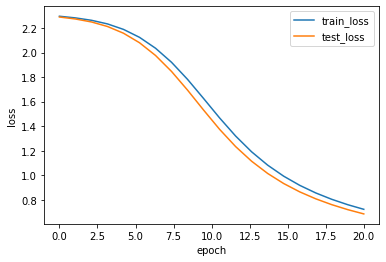

In [4]:
import torch
import numpy as np
import random
from IPython import display
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms

#下载MNIST手写数据集 :包括训练集和测试集
train_dataset = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=True,  download=True, transform=transforms.ToTensor())  
test_dataset = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=False,  download=True, transform=transforms.ToTensor())  

batch_size = 32  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)  
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=0) 

#超参数初始化
num_inputs=784 #28*28
num_hiddens=256
num_outputs=10
#参数初始化
W1 = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_hiddens)),dtype=torch.float32)
b1 = torch.zeros(1,dtype=torch.float32)
W2 = torch.tensor(np.random.normal(0,0.01,(num_hiddens,num_outputs)),dtype=torch.float32)
b2 = torch.zeros(1,dtype=torch.float32)
params = [W1,b2,W2,b2]
for param in params:
    param.requires_grad_(requires_grad = True)

#x为矩阵tensor
##对于一个小批量样本的训练而言，X=32*784，W=784*256，得到的relu函数参数：32*256
##表示32个样本，每个样本在256个隐藏层神经元上的输出值
def relu(x):
    x = torch.max(x,torch.tensor(0.0))
    return x
def net (X):
    #因为我们忽略了空间结构，所以我们使用reshape将每个二维图像转换为一个长度为num_inputs的向量。
    X = X.reshape((-1,num_inputs))#X.shape为torch.Size([32, 1, 28, 28]) 展平为32*728
    H = relu(torch.mm(X,W1)+b1)
    return (torch.mm(H,W2)+b2)#所得结果shape为32*10,代表32个样本,分别在10个输出层神经元上的输出。

loss = torch.nn.CrossEntropyLoss()
def SGD(paras,lr,batch_size):  
    for param in params:  
        param.data -= lr * param.grad/batch_size
#返回准确率以及loss
flag=0
def evaluate_accuracy_loss(net, data_iter):
    acc_sum=0.0
    loss_sum=0.0
    n=0
    global flag
    for X,y in data_iter:
        y_hat = net(X)
        #if flag==0:print (y_hat)#测试一下y_hat是否已经softmax激活
        #flag = 1
        acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
        l = loss(y_hat,y)
        loss_sum += l.item()*y.shape[0]#由于loss(y_hat,y)默认为求平均，因此*y.shape[0]意味着求和。
        n+=y.shape[0]
    return acc_sum/n,loss_sum/n
#记录列表（list），存储训练集和测试集上经过每一轮次，loss的变化
def train (net,train_iter,test_iter,loss,num_epochs,batch_size,params = None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):#外循环控制循环轮次---跑完一轮，也就把数据走了一遍
        train_l_sum=0.0#记录训练集上的损失
        train_acc_num=0.0#记录训练集上的准确数
        n =0.0
        #step1在训练集上，进行小批量梯度下降更新参数
        for X,y in train_iter:#内循环控制训练批次
            y_hat = net(X)
            #保证y与y_hat维度一致，否则将会发生广播
            l = loss(y_hat,y)#这里计算出的loss是已经求和过的，l.size = torch.Size([]),即说明loss为表示*标量*的tensor`
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr,batch_size)
            else:
                optimizer.step()
            #每一个迭代周期中得到的训练集上的loss累积进来
            train_l_sum += l.item()*y.shape[0]
            #计算训练样本的准确率---将每个迭代周期中预测正确的样本数累积进来
            train_acc_num += (y_hat.argmax(dim=1)==y).sum().item()#转为int类型
            n += y.shape[0]
        #step2 每经过一个轮次的训练， 记录训练集和测试集上的loss
        #注意要取平均值，loss默认求了sum
        train_loss.append(train_l_sum/n)#训练集loss
        test_acc,test_l = evaluate_accuracy_loss(net,test_iter)
        test_loss.append(test_l)
        print("epoch %d,train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f"%(epoch+1,train_loss[epoch],test_loss[epoch],train_acc_num/n,test_acc)) 
    return train_loss, test_loss
lr = 0.01
num_epochs=20
train_loss,test_loss=train(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

import matplotlib.pyplot as plt
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()